In [1]:
import io
import math

import torch
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import datasets, train, models

import pytorch_lightning as pl

from compressai.zoo import bmshj2018_hyperprior

In [2]:
def pillow_encode(img, fmt='jpeg', quality=10):
    tmp = io.BytesIO()
    img.save(tmp, format=fmt, quality=quality)
    tmp.seek(0)
    filesize = tmp.getbuffer().nbytes
    bpp = filesize * float(8) / (img.size[0] * img.size[1])
    rec = Image.open(tmp)
    return rec, bpp

In [3]:
def find_closest_bpp(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        if bpp > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp
    
def mse(a, b):
    a = np.asarray(a).astype(np.float32)
    b = np.asarray(b).astype(np.float32)
    return np.mean(np.square(a - b))

def psnr(a, b):
        return psnr_from_mse(mse(a, b))
    
def psnr_from_mse(mse, max_value=255):
        return 20 * math.log10(max_value) - 10. * math.log10(mse)

In [122]:
def plot_rate_distortion_curves(data, data_range=1):
    fig, ax = plt.subplots(figsize=(8, 5))

    for label, (bpps, dists) in data.items():
        
        if label == "JPEG":
            data_range = 255
        else:
            data_range = 1
        ax.plot(bpps, tuple(psnr_from_mse(d, data_range) for d in dists), 'o-')
        

    ax.legend(data.keys())
    ax.set_title("Rate-Distortion Curves")
    ax.set_xlabel("Bites Per Pixel")
    ax.set_ylabel("PSNR")
    plt.show()

In [5]:
def compare_with_classical(rec_net, original_image, target_bpp):
    rec_jpeg, bpp_jpeg = find_closest_bpp(target_bpp, original_image, fmt="jpeg")
    rec_webp, bpp_webp = find_closest_bpp(target_bpp, original_image, fmt='webp')

    fig, axes = plt.subplots(2, 2, figsize=(18, 15))
    for ax in axes.ravel():
        ax.axis('off')

    fig.title = 'yolo'
    axes[0][0].imshow(original_image)
    axes[0][0].title.set_text('Original')
    axes[0][1].imshow(rec_net)
    axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp, {mse(rec_net, original_image):.2f} mse')
    axes[1][0].imshow(rec_jpeg)
    axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp, {mse(rec_jpeg, original_image):.2f} mse')
    axes[1][1].imshow(rec_webp)
    axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp, {mse(rec_webp, original_image):.2f} mse')

    plt.show()

In [6]:
def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [7]:
def run_pretrained_model(image, model, quality, verbose=True):
    device = 'cpu'

    net = model(quality=quality, pretrained=True).eval().to(device)

    if type(image) == torch.Tensor:
        x = image
    else:
        x = transforms.ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        out_net = net.forward(x)
    
    out_net['x_hat'].clamp_(0, 1)

    if type(image) == torch.Tensor:
        rec_net = out_net['x_hat'].squeeze().cpu()
    else:
        rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
    
    if verbose:
        print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

    return compute_bpp(out_net), rec_net

In [111]:
def mse_across_tasks(batch, model):
    """
    We want to return an list of mse and bpp values for each task
    """
    
    ans = {key: tuple((list(), list())) for key in batch.keys()}


    # for all tasks
    for task, image_tensors in batch.items():
        # for all bpp values
        
        if model in ("JPEG", "WEBP"):
            for bpp in (0.2, 0.5, 0.8, 1):        

                batch_bpps = []
                batch_mses = []

                # for all images of the task in a batch
                for image_tensor in image_tensors:

                    image = transforms.ToPILImage()(image_tensor)

                    reconstruction, bpp = find_closest_bpp(bpp, image, fmt=model.lower())
#                     print(reconstruction.shape, image.shape)

                    batch_mses.append(mse(reconstruction.to, image))
                    batch_bpps.append(bpp)
                    
                ans[task][0].append(np.mean(batch_bpps))
                ans[task][1].append(np.mean(batch_mses))

        elif model == "pretr":
            for quality in (1, 2, 3, 4, 5):
                
                if task == "depth_euclidean":
                    input_data = (image_tensors/image_tensors.max()).repeat(1, 3, 1, 1)
                else:
                    input_data = image_tensors

                bpp, reconstructions = run_pretrained_model(input_data, bmshj2018_hyperprior, quality, False)
                
                ans[task][0].append(bpp)
                ans[task][1].append(mse(reconstructions, input_data))
        else:
            raise NotImplementedError()

    mean_bpp = np.mean(list(np.array(ans[task][0]) for task in ans.keys()), axis=0)
    mean_mse = np.mean(list(np.array(ans[task][1]) for task in ans.keys()), axis=0)
    
    return ans, (mean_bpp, mean_mse)


In [9]:
pl.seed_everything(21)

MODEL_PATH = "../model-4-01.ckpt"
TASKS = ["rgb", "depth_euclidean", "normal"]
DATASET = "clevr"

default_collate = datasets.transforms.make_collate_fn(TASKS)

_, dataloader = train.get_dataloader(
    dataset_name=DATASET,
    batch_size=64,
    num_workers=0,
    tasks=TASKS,
    is_train=True,
    collate=default_collate,
)

Global seed set to 21


In [10]:
TASK = "rgb"

batch = next(iter(dataloader))
original_image = transforms.ToPILImage()(batch[TASK][0])

In [11]:
ckpt_params = torch.load(MODEL_PATH, map_location="cpu")

model_type = models.MultiTaskMixedLatentCompressor
model_type = models.MultiTaskSharedLatentCompressor

compressor = model_type(**ckpt_params["hyper_parameters"]).eval()
compressor.load_state_dict(ckpt_params["state_dict"])
compressor.update_bottleneck_values()

compressed_data, bytes, likelihoods = compressor.compress(batch, print_info=True)
strings, shape = compressed_data["strings"], compressed_data["shape"]

decompressed_batch = compressor.decompress(strings, shape)

decompressed_image = decompressed_batch[TASK][0].detach()

decompressed_image_pil = transforms.ToPILImage()(decompressed_image)

Number of actual bytes in a string is: 159580, which gives a BPP = 0.10
Estimated BPP (compression loss) is: 0.10


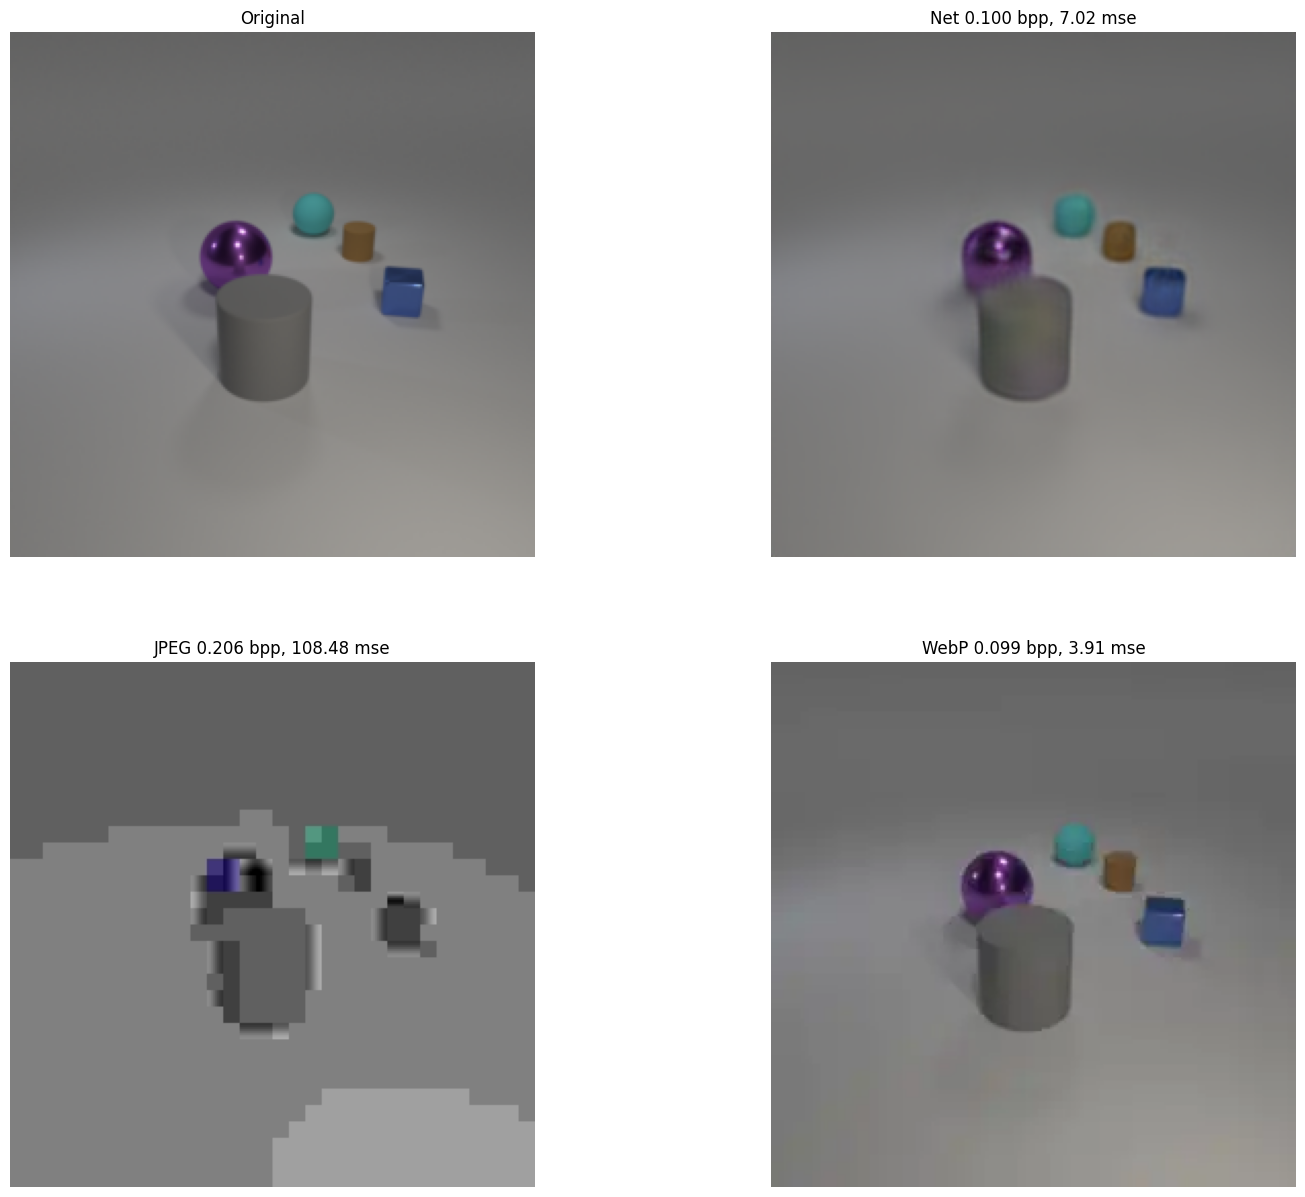

In [12]:
compare_with_classical(decompressed_image_pil, original_image, target_bpp=0.1)

---

But this is for RGB natural looking images. Will it also outperform on normals?

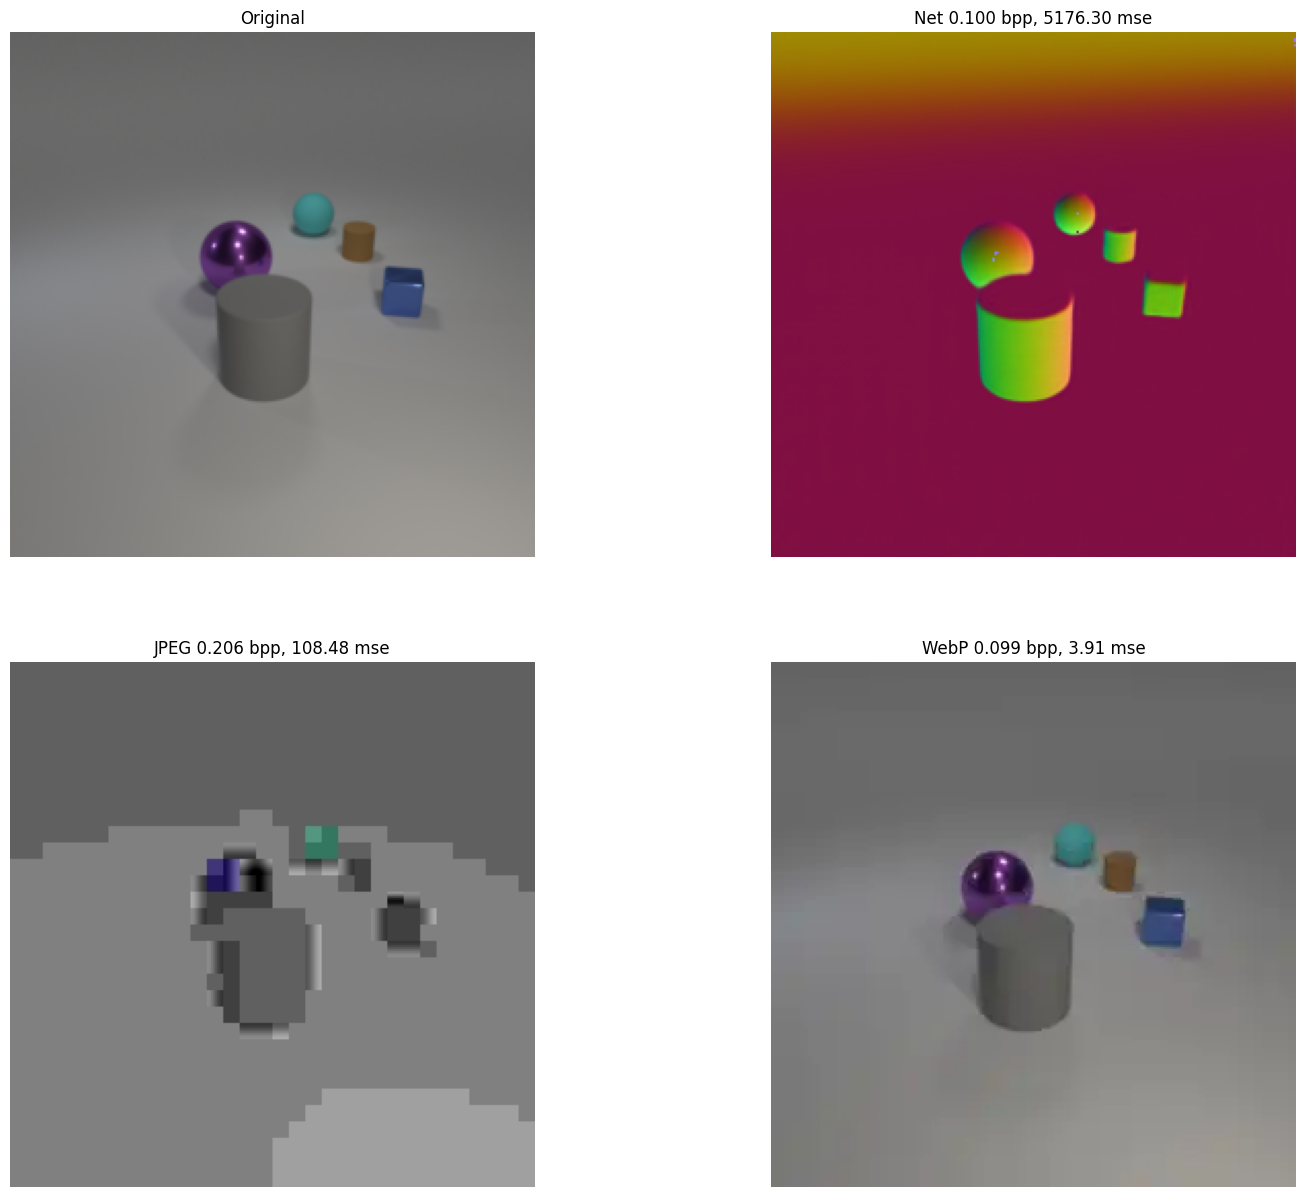

In [13]:
decompressed_image_pil = transforms.ToPILImage()(decompressed_batch["normal"][0].detach())
compare_with_classical(decompressed_image_pil, original_image, target_bpp=0.1)

Parameters: 5075843


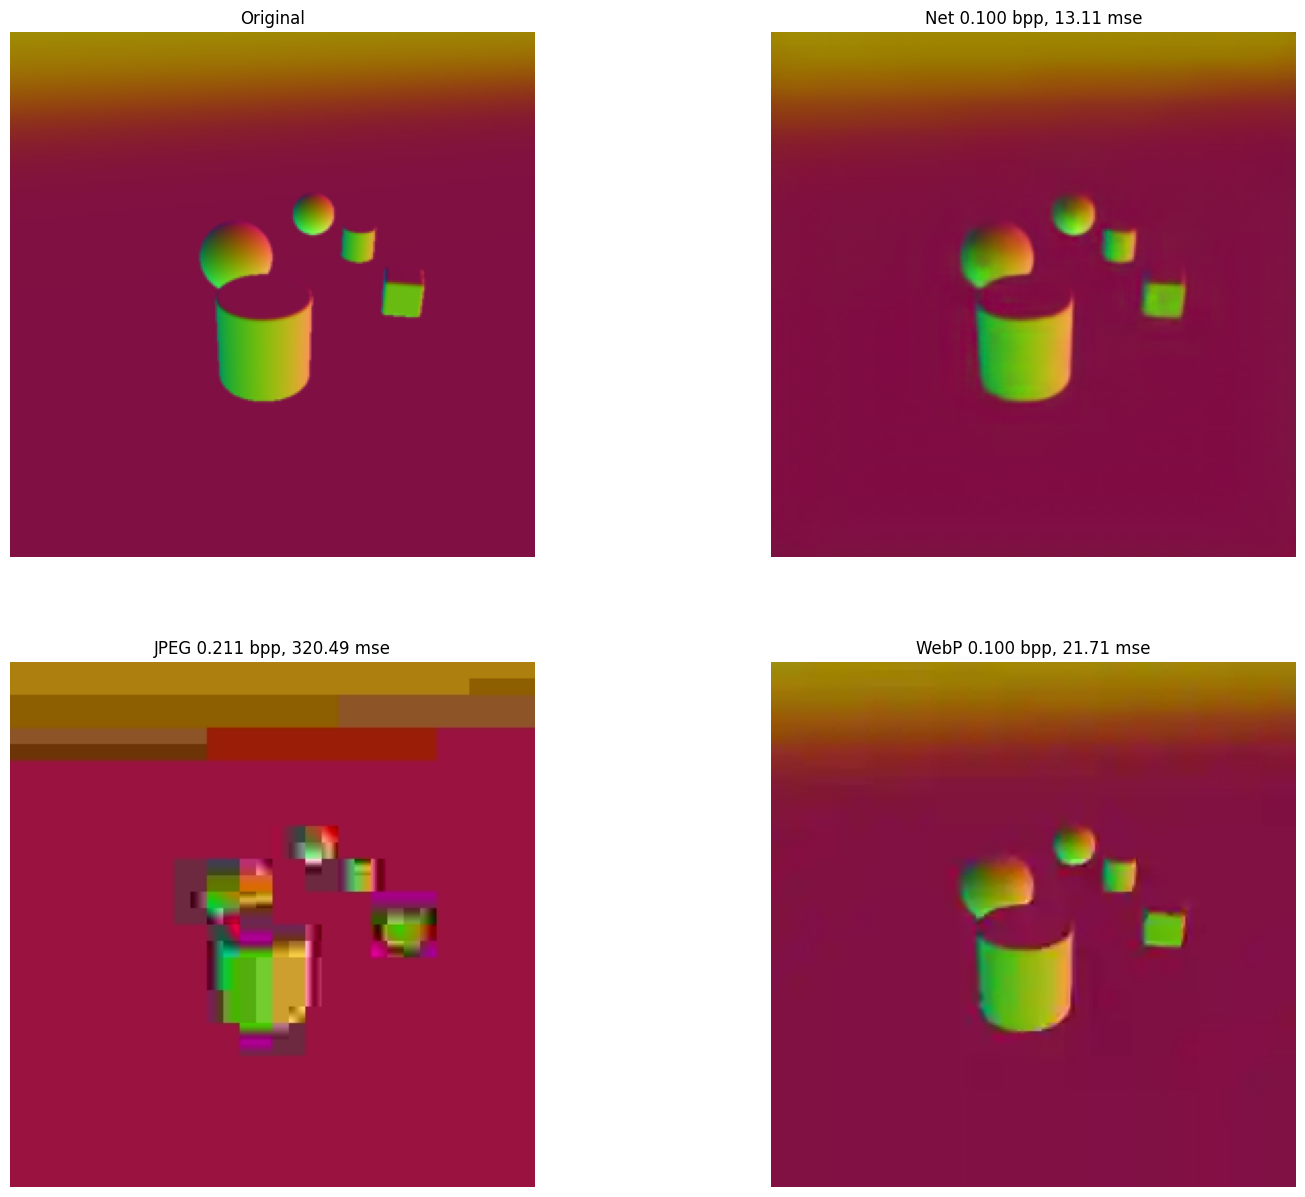

In [14]:
original_image = transforms.ToPILImage()(batch["normal"][0])

bpp, rec_net = run_pretrained_model(original_image, bmshj2018_hyperprior, quality=4)
compare_with_classical(rec_net, original_image, target_bpp=0.1)

---

### Compute MSE and BPP for JPEG

In [114]:
jpeg_ans, (jpeg_bpps, jpeg_mse) = mse_across_tasks(batch, model="JPEG")

In [115]:
# webp_ans, (webp_bpps, webp_mse) = mse_across_tasks(batch, model="WEBP")

---

### Compute MSE and BPP for Pretrained Scale Hyperprior

In [116]:
pretr_ans, (pretr_bpps, pretr_mse) = mse_across_tasks(batch, model="pretr")

# Rate-Distortion plots

**Note** Here, the reconstruction loss is a SUM of 3 task losses

## 1. Multi-Task All Model Comparison

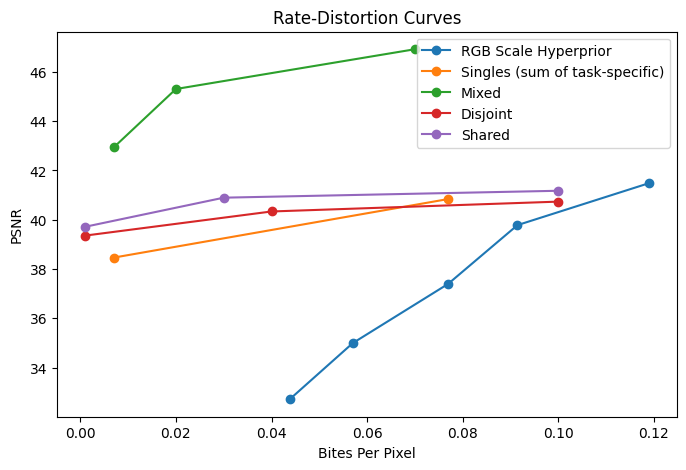

In [124]:
# {name: (bpps, dists)},
#   ...
# }
model_values = {
                "RGB Scale Hyperprior":       (pretr_bpps, pretr_mse),
    
                # here are singles with 300 latent channels at ~900 epochs
                "Singles (sum of task-specific)":    ([0.077, 0.007], 
                                               np.array([16.2, 28]) / 256 / 256 / 3),

                "Mixed":                      ([0.07, 0.02, 0.007], 
                                               np.array([4, 5.8, 10]) / 256 / 256 / 3),  # ???__4__???

                "Disjoint":                 ([0.1, 0.04, 0.001], 
                                             np.array([16.6, 18.2, 22.8]) / 256 / 256 / 3),

                "Shared":                   ([0.1, 0.03, 0.001], 
                                             np.array([15, 16, 21]) / 256 / 256 / 3),
    
#                 "JPEG":                       (jpeg_bpps, jpeg_mse)
               }

plot_rate_distortion_curves(model_values)

## 2. RD Curves across tasks 

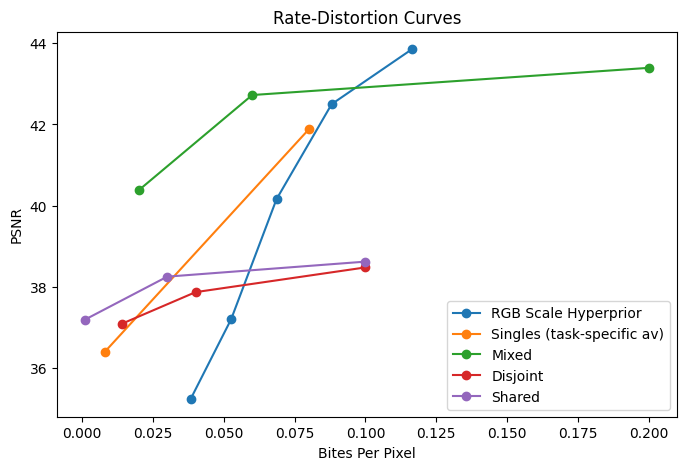

In [127]:
# {name: (bpps, dists),
#         ...
# }

model_values = {
                "RGB Scale Hyperprior":       (pretr_ans["rgb"][0], pretr_ans["rgb"][1]),
    
                "Singles (task-specific av)":    ([0.08, 0.008], 
                                                  np.array([4.25, 15]) / 256 / 256),

                "Mixed":                      ([0.2, 0.06, 0.02], 
                                               np.array([3, 3.5, 6]) / 256 / 256),  # ???__3__???

                "Disjoint":                 ([0.1, 0.04, 0.014], 
                                               np.array([9.3, 10.7, 12.8]) / 256 / 256),  # ???__3__???

                "Shared":                   ([0.1, 0.03, 0.001], 
                                             np.array([9, 9.8, 12.5]) / 256 / 256),
#                 "JPEG":                       (jpeg_ans["rgb"][0], jpeg_ans["rgb"][1]),
    
               }

plot_rate_distortion_curves(model_values)

---

### Let's see how is the memmory disitributed by classes

In [287]:
ckpt_params = torch.load("../model-3-0001.ckpt", map_location="cpu")

# model_type = models.MultiTaskMixedLatentCompressor
# model_type = models.MultiTaskSharedLatentCompressor
model_type = models.MultiTaskDisjointLatentCompressor

compressor = model_type(**ckpt_params["hyper_parameters"]).eval()
compressor.load_state_dict(ckpt_params["state_dict"])
compressor.update_bottleneck_values()

True

In [288]:
compressed_data, bytes, likelihoods = compressor.compress(batch, print_info=True)

Number of actual bytes in a string is: 21800, which gives a BPP = 0.01
Estimated BPP (compression loss) is: 0.01


In [289]:
num_pixels = 256 * 256
y_likelihoods = likelihoods["y"]
z_likelihoods = likelihoods["z"]

channel_bpps = np.array([torch.log(y_likelihoods[:, c]).sum().item() / (-math.log(2) * num_pixels * len(batch["rgb"]))
                for c in range(y_likelihoods.shape[1])])

94% of z's are 1

In [290]:
(z_likelihoods > 0.99).sum()/torch.prod(torch.tensor(z_likelihoods.shape)) * 100

tensor(92.0635)

In [291]:
(y_likelihoods > 0.99).sum()/torch.prod(torch.tensor(y_likelihoods.shape)) * 100

tensor(81.2357)

In [292]:
def plot_by_task(data, taks_borders, plot="scatter"):
    
    n_tasks = len(taks_borders) - 1
    
    task_colors = ["r", "g", "b"]
    legend = ["rgb", "depth", "normals"]
    
    if n_tasks == 4:
        legend.append("shared")
        task_colors.append("orange")
        
    if plot == "scatter":
        fig, ax = plt.subplots(figsize=(9, 6))

        for i in range(n_tasks):
            l = taks_borders[i]
            r = taks_borders[i + 1]

            ax.hlines(data[l: r].mean(), xmin=l, xmax=r, colors=task_colors[i])

            ax.scatter(range(l, r), data[l: r], c=task_colors[i], s=3, label=i)

#         ax.title.set_text('Per-channel bit-rate')
#         ax.set_xlabel('Channel index')
        ax.set_ylabel('BPP')
        
    elif plot == "box":
        plt.boxplot([data[taks_borders[i]: taks_borders[i + 1]] for i in range(n_tasks)])
        plt.title('Per-task bit-rate distributions')
        plt.xlabel('Task index (rgb, depth, normal)')
        plt.ylabel('Task bpp')
        
    elif plot == "bar":
        plt.bar(legend, [sum(data[taks_borders[i]: taks_borders[i + 1]]) for i in range(n_tasks)], color=task_colors)
        plt.title('Per-task bit-rate distributions')
        plt.xlabel('Task')
        plt.ylabel('BPP')
        
#     ax.legend(legend)
    
        
    plt.show()

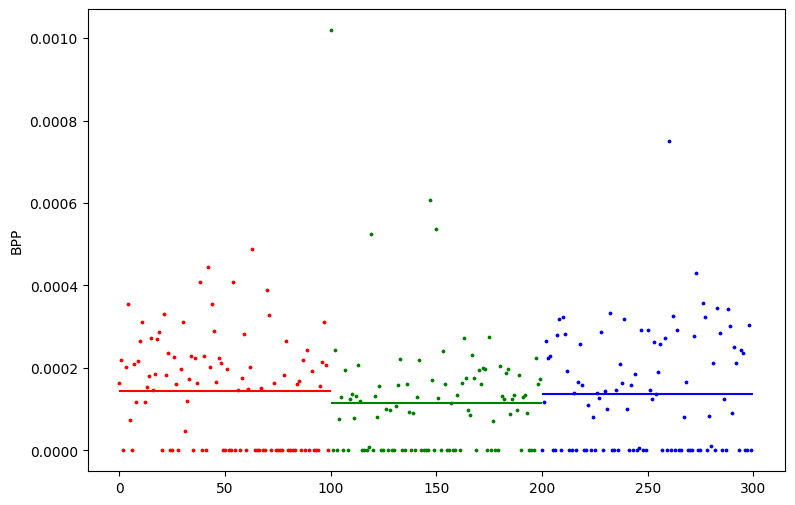

In [293]:
task_channels = range(0, 301, 100)

plot_by_task(channel_bpps, task_channels, plot="scatter")

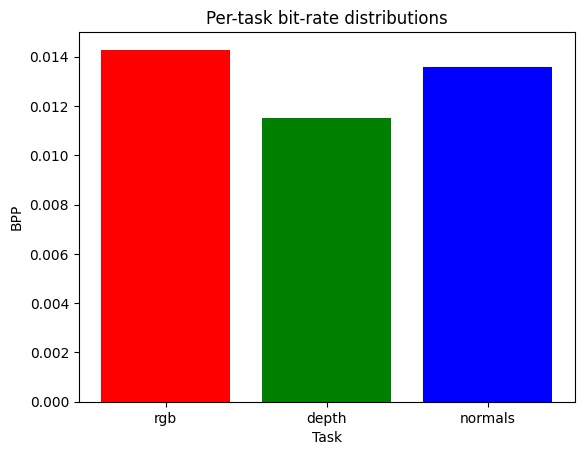

In [265]:
plot_by_task(channel_bpps, task_channels, plot="bar")